# Generate yellow smiley faces 🙂

## load dependencies
* matplotlib for plotting
* numpy for array handling
* json for loading emoji description
* mpimg and glob for reading PNG
* tensorflow for GAN

In [2]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import json
import glob
import random
from pprint import pprint

## filter and load emoji files

In [3]:
# filter only person emojis without tones
with open('emojione-2.2.7/emoji.json') as data_file:
    emojis = json.load(data_file)

#smileys = {k: v for k, v in emojis.items() if v["category"] == "people" or v["category"] == "activity"}
smileys = {k: v for k, v in emojis.items() if v["category"] != "symbols" and v["category"] != "flags" and v["category"] != "regional"}
pprint("original dictionary:")
pprint({key: smileys[key] for key in list(smileys.keys())[:1]})

smileys = {k: {"keywords": v["keywords"], "unicode": v["unicode"], "ascii": v["aliases_ascii"], "name": v["name"]} for k,v in smileys.items()}
pprint("minimized dictionary: {} left out of {} emojis".format(len(smileys), len(emojis)))
pprint({key: smileys[key] for key in list(smileys.keys())[:2]})

'original dictionary:'
{'older_woman_tone1': {'aliases': [':grandma_tone1:'],
                       'aliases_ascii': [],
                       'category': 'people',
                       'code_decimal': '&#128117;&#127995;',
                       'emoji_order': '130',
                       'keywords': [],
                       'name': 'older woman tone 1',
                       'shortname': ':older_woman_tone1:',
                       'unicode': '1f475-1f3fb',
                       'unicode_alt': ''}}
'minimized dictionary: 1262 left out of 1820 emojis'
{'first_quarter_moon': {'ascii': [],
                        'keywords': ['space', 'sky', 'moon'],
                        'name': 'first quarter moon symbol',
                        'unicode': '1f313'},
 'older_woman_tone1': {'ascii': [],
                       'keywords': [],
                       'name': 'older woman tone 1',
                       'unicode': '1f475-1f3fb'}}


In [4]:
# filter all files for the given smiley unicodes
image_paths = glob.glob("./emojione-2.2.7/assets/png/*.png")
#pprint(image_paths[:10])
filtered_files = [v["unicode"] for k,v in smileys.items()]
filtered_files = [next(filter(lambda p: f+".png" in p, image_paths)) for f in filtered_files]

In [5]:
# load all files
images = [mpimg.imread(f) for f in filtered_files]
images = [i for i in images if i.shape == (64, 64, 4)]
pprint(len(images))

1242


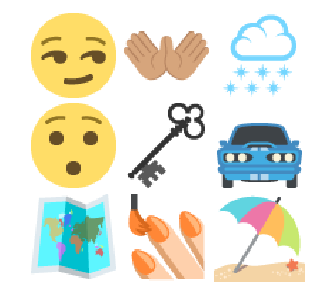

In [6]:
# display 20 random emojis
column_count = 3 # emojis per column
display_count = column_count**2 # total number of emojis to show (aligns neatly if it's a square)

f, axarr = plt.subplots(display_count//column_count, column_count, sharex=True, sharey=True, figsize=(5,5))
for (i, img) in enumerate(random.sample(images, display_count)):
    a = axarr[i%(display_count//column_count), i//(display_count//column_count)]
    a.axis("off")
    a.imshow(img)
plt.subplots_adjust(wspace=0, hspace=0)

## preprocessing functions

In [7]:
def scale(x, min_val=-1, max_val=1):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    x = x * (max_val - min_val) + min_val
    return x

In [8]:
def get_batches(images, batch_size, shuffle=True):
    images = np.array(images)
    if shuffle:
        idx = np.arange(len(images))
        np.random.shuffle(idx)
        images = images[idx]
    n_batches = len(images)//batch_size
    for i in range(0, len(images), batch_size):
        x = images[i:i+batch_size]
        yield x

In [9]:
print(images[0].shape)

(64, 64, 4)


## define network


In [10]:
# inputs
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(dtype=tf.float32, shape=(None, *real_dim), name="input_real")
    inputs_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="input_z")

    return inputs_real, inputs_z

In [11]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        fc = tf.layers.dense(inputs=z, units=4*4*256, activation=None)
        conv1 = tf.reshape(fc, shape=(-1, 4, 4, 256))
        conv1 = tf.layers.batch_normalization(inputs=conv1, training=training)
        conv1 = tf.maximum(conv1, alpha*conv1)
        # > 4*4*
        
        conv2 = tf.layers.conv2d_transpose(inputs=conv1, filters=128, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv2 = tf.layers.batch_normalization(inputs=conv2, training=training)
        conv2 = tf.maximum(conv2, alpha*conv2)
        # > 16*16*
        
        conv3 = tf.layers.conv2d_transpose(inputs=conv2, filters=32, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv3 = tf.layers.batch_normalization(inputs=conv3, training=training)
        conv3 = tf.maximum(conv3, alpha*conv3)
        # > 32*32*
        
        
        # Output layer, 64*64*4
        logits = tf.layers.conv2d_transpose(inputs=conv3, filters=output_dim, kernel_size=5, strides=2, padding='SAME', activation=None)
        
        out = tf.tanh(logits)
        
        return out

In [12]:
def discriminator(x, reuse=False, alpha=0.2):
    def lRU(x, alpha):
        return tf.maximum(x, x * alpha)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        conv1 = tf.layers.conv2d(inputs=x, filters=32, kernel_size=5, strides=2, activation=None)
        conv1 = tf.maximum(conv1, alpha*conv1)
        # > 16x16x
        
        conv2 = tf.layers.conv2d(inputs=conv1, filters=128, kernel_size=5, strides=2, activation=None)
        conv2 = tf.layers.batch_normalization(inputs=conv2, training=True)
        conv2 = tf.maximum(conv2, alpha*conv2)
        # > 8x8x
        
        conv3 = tf.layers.conv2d(inputs=conv2, filters=256, kernel_size=5, strides=2, activation=None)
        conv3 = tf.layers.batch_normalization(inputs=conv3, training=True)
        conv3 = tf.maximum(conv3, alpha*conv3)
        # > 4x4x
        
        flat = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(inputs=conv3, units=1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [13]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [15]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [16]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [17]:
def train(net, images, epochs, batch_size, print_every=50, show_every=500, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x in get_batches(images, batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 4, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

In [18]:
# hyper params
real_size = (64,64,4)
z_size = 100
learning_rate = 0.0003
batch_size = 256
epochs = 1000
alpha = 0.1
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 10/1000... Discriminator Loss: 1.1664... Generator Loss: 0.7703
Epoch 20/1000... Discriminator Loss: 0.8861... Generator Loss: 1.0150
Epoch 30/1000... Discriminator Loss: 0.7105... Generator Loss: 1.2057
Epoch 40/1000... Discriminator Loss: 0.6113... Generator Loss: 1.3864
Epoch 50/1000... Discriminator Loss: 0.5119... Generator Loss: 1.4829
Epoch 60/1000... Discriminator Loss: 0.5241... Generator Loss: 1.4665
Epoch 70/1000... Discriminator Loss: 0.6862... Generator Loss: 1.5373
Epoch 80/1000... Discriminator Loss: 0.7032... Generator Loss: 1.3550
Epoch 90/1000... Discriminator Loss: 0.8522... Generator Loss: 1.4155
Epoch 100/1000... Discriminator Loss: 0.6615... Generator Loss: 1.4211


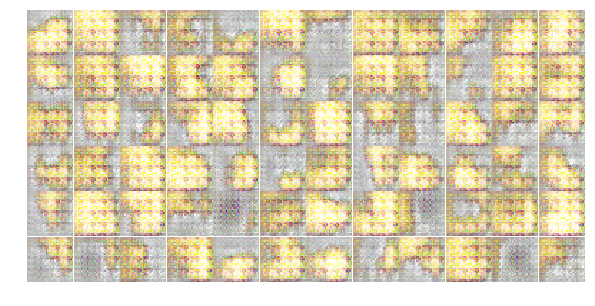

Epoch 110/1000... Discriminator Loss: 0.7246... Generator Loss: 1.2765
Epoch 120/1000... Discriminator Loss: 0.9092... Generator Loss: 1.1933
Epoch 130/1000... Discriminator Loss: 0.7806... Generator Loss: 1.4460
Epoch 140/1000... Discriminator Loss: 0.9855... Generator Loss: 0.8436
Epoch 150/1000... Discriminator Loss: 0.6085... Generator Loss: 1.5392
Epoch 160/1000... Discriminator Loss: 0.8172... Generator Loss: 1.9032
Epoch 170/1000... Discriminator Loss: 0.6732... Generator Loss: 1.7728
Epoch 180/1000... Discriminator Loss: 0.7472... Generator Loss: 1.6399
Epoch 190/1000... Discriminator Loss: 0.8635... Generator Loss: 0.9191
Epoch 200/1000... Discriminator Loss: 0.6600... Generator Loss: 1.5480


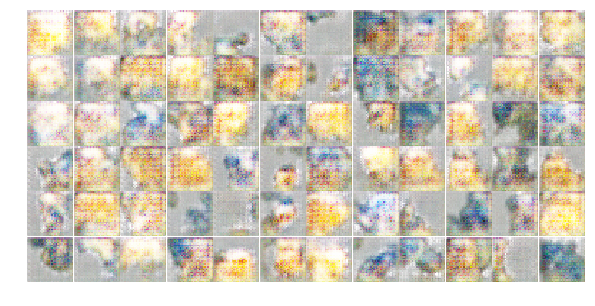

Epoch 210/1000... Discriminator Loss: 0.6606... Generator Loss: 1.2759
Epoch 220/1000... Discriminator Loss: 0.6094... Generator Loss: 1.4012
Epoch 230/1000... Discriminator Loss: 1.1298... Generator Loss: 2.2363
Epoch 240/1000... Discriminator Loss: 0.6350... Generator Loss: 1.9717
Epoch 250/1000... Discriminator Loss: 0.7272... Generator Loss: 1.7378
Epoch 260/1000... Discriminator Loss: 0.5355... Generator Loss: 1.6421
Epoch 270/1000... Discriminator Loss: 0.7073... Generator Loss: 1.2307
Epoch 280/1000... Discriminator Loss: 0.6305... Generator Loss: 2.2788
Epoch 290/1000... Discriminator Loss: 0.6325... Generator Loss: 1.4433
Epoch 300/1000... Discriminator Loss: 0.4570... Generator Loss: 1.5557


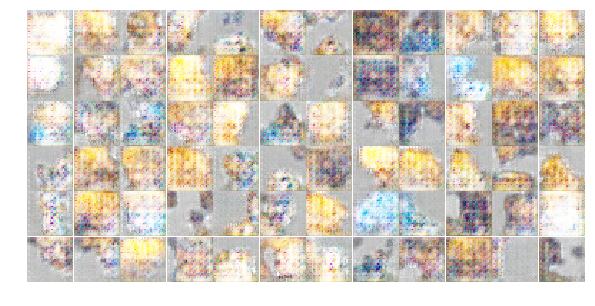

Epoch 310/1000... Discriminator Loss: 0.5510... Generator Loss: 2.2897
Epoch 320/1000... Discriminator Loss: 1.0819... Generator Loss: 0.7452
Epoch 330/1000... Discriminator Loss: 0.4155... Generator Loss: 1.8145
Epoch 340/1000... Discriminator Loss: 0.4543... Generator Loss: 1.4709
Epoch 350/1000... Discriminator Loss: 0.4403... Generator Loss: 1.9624
Epoch 360/1000... Discriminator Loss: 0.5538... Generator Loss: 1.2934
Epoch 370/1000... Discriminator Loss: 0.4027... Generator Loss: 2.0970
Epoch 380/1000... Discriminator Loss: 0.3300... Generator Loss: 2.1380
Epoch 390/1000... Discriminator Loss: 0.3277... Generator Loss: 2.4200
Epoch 400/1000... Discriminator Loss: 0.3383... Generator Loss: 2.2888


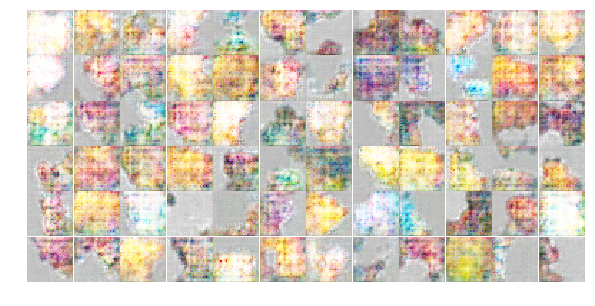

Epoch 410/1000... Discriminator Loss: 1.2004... Generator Loss: 0.6538
Epoch 420/1000... Discriminator Loss: 0.7942... Generator Loss: 3.1020
Epoch 430/1000... Discriminator Loss: 0.3660... Generator Loss: 1.9944
Epoch 440/1000... Discriminator Loss: 0.3659... Generator Loss: 2.4249
Epoch 450/1000... Discriminator Loss: 0.3093... Generator Loss: 1.9353
Epoch 460/1000... Discriminator Loss: 0.3668... Generator Loss: 2.4549
Epoch 470/1000... Discriminator Loss: 0.2709... Generator Loss: 2.0152
Epoch 480/1000... Discriminator Loss: 0.2844... Generator Loss: 2.1902
Epoch 490/1000... Discriminator Loss: 0.3767... Generator Loss: 2.2374
Epoch 500/1000... Discriminator Loss: 0.3199... Generator Loss: 2.6208


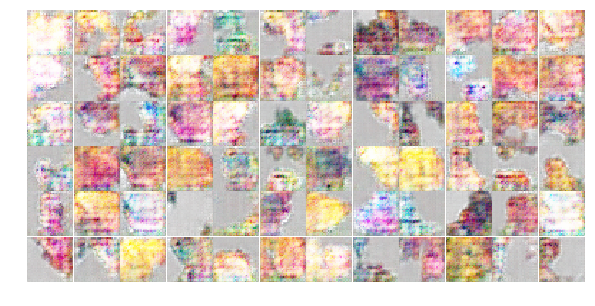

Epoch 510/1000... Discriminator Loss: 0.5337... Generator Loss: 1.8615
Epoch 520/1000... Discriminator Loss: 0.3401... Generator Loss: 1.5989
Epoch 530/1000... Discriminator Loss: 0.3159... Generator Loss: 2.9335
Epoch 540/1000... Discriminator Loss: 0.2964... Generator Loss: 2.1382
Epoch 550/1000... Discriminator Loss: 0.2567... Generator Loss: 2.2202
Epoch 560/1000... Discriminator Loss: 0.2466... Generator Loss: 2.7377
Epoch 570/1000... Discriminator Loss: 0.2183... Generator Loss: 3.2367
Epoch 580/1000... Discriminator Loss: 0.2472... Generator Loss: 2.0704
Epoch 590/1000... Discriminator Loss: 0.6249... Generator Loss: 0.9662
Epoch 600/1000... Discriminator Loss: 1.0233... Generator Loss: 0.7051


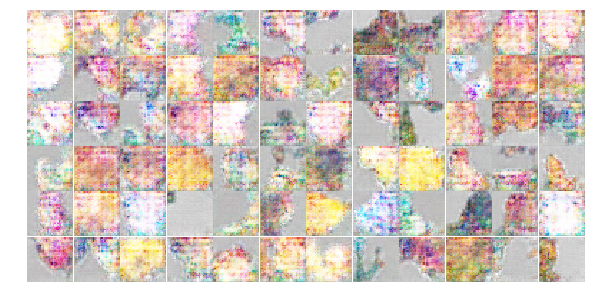

Epoch 610/1000... Discriminator Loss: 0.2335... Generator Loss: 2.7021
Epoch 620/1000... Discriminator Loss: 0.3989... Generator Loss: 1.5405
Epoch 630/1000... Discriminator Loss: 0.3976... Generator Loss: 2.1527
Epoch 640/1000... Discriminator Loss: 0.2775... Generator Loss: 3.4871
Epoch 650/1000... Discriminator Loss: 0.4066... Generator Loss: 3.4261
Epoch 660/1000... Discriminator Loss: 0.1646... Generator Loss: 2.6194
Epoch 670/1000... Discriminator Loss: 0.6560... Generator Loss: 1.9789
Epoch 680/1000... Discriminator Loss: 0.1835... Generator Loss: 2.9089
Epoch 690/1000... Discriminator Loss: 0.2710... Generator Loss: 1.9824
Epoch 700/1000... Discriminator Loss: 0.7553... Generator Loss: 4.1198


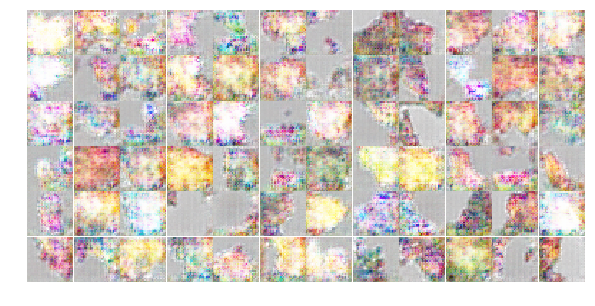

Epoch 710/1000... Discriminator Loss: 0.2138... Generator Loss: 2.2315
Epoch 720/1000... Discriminator Loss: 0.2225... Generator Loss: 2.0644
Epoch 730/1000... Discriminator Loss: 0.2801... Generator Loss: 2.2324
Epoch 740/1000... Discriminator Loss: 0.1958... Generator Loss: 2.5191
Epoch 750/1000... Discriminator Loss: 0.1598... Generator Loss: 2.6109
Epoch 760/1000... Discriminator Loss: 0.2377... Generator Loss: 3.1632
Epoch 770/1000... Discriminator Loss: 0.1871... Generator Loss: 2.2099
Epoch 780/1000... Discriminator Loss: 0.1957... Generator Loss: 3.3569
Epoch 790/1000... Discriminator Loss: 0.1889... Generator Loss: 2.2363
Epoch 800/1000... Discriminator Loss: 0.1396... Generator Loss: 3.3748


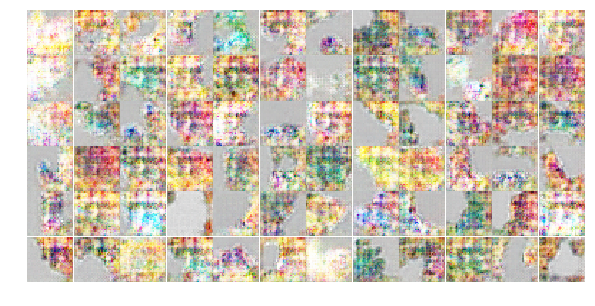

Epoch 810/1000... Discriminator Loss: 0.1355... Generator Loss: 3.1891
Epoch 820/1000... Discriminator Loss: 0.1603... Generator Loss: 2.5653
Epoch 830/1000... Discriminator Loss: 0.1720... Generator Loss: 2.6902
Epoch 840/1000... Discriminator Loss: 0.2090... Generator Loss: 2.5118
Epoch 850/1000... Discriminator Loss: 0.1946... Generator Loss: 2.6406
Epoch 860/1000... Discriminator Loss: 0.2039... Generator Loss: 2.2133
Epoch 870/1000... Discriminator Loss: 0.2106... Generator Loss: 3.1741
Epoch 880/1000... Discriminator Loss: 0.1706... Generator Loss: 2.3871
Epoch 890/1000... Discriminator Loss: 0.3780... Generator Loss: 3.1451
Epoch 900/1000... Discriminator Loss: 0.1552... Generator Loss: 2.7320


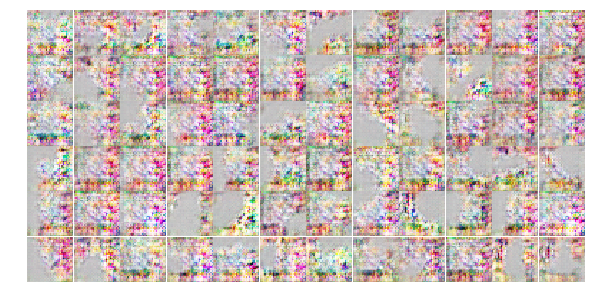

Epoch 910/1000... Discriminator Loss: 0.1617... Generator Loss: 2.9959
Epoch 920/1000... Discriminator Loss: 0.2172... Generator Loss: 2.8708
Epoch 930/1000... Discriminator Loss: 0.1355... Generator Loss: 2.8783
Epoch 940/1000... Discriminator Loss: 0.1772... Generator Loss: 2.5853
Epoch 950/1000... Discriminator Loss: 0.1665... Generator Loss: 3.0178
Epoch 960/1000... Discriminator Loss: 0.1834... Generator Loss: 2.9981
Epoch 970/1000... Discriminator Loss: 0.2838... Generator Loss: 2.7805
Epoch 980/1000... Discriminator Loss: 0.1547... Generator Loss: 2.8136
Epoch 990/1000... Discriminator Loss: 0.1012... Generator Loss: 2.9770
Epoch 1000/1000... Discriminator Loss: 0.2582... Generator Loss: 3.7239


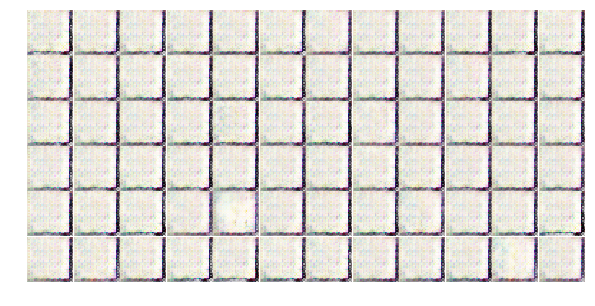

In [19]:
# Load the data and train the network here
losses, samples = train(net, images, epochs, batch_size, figsize=(10,5))

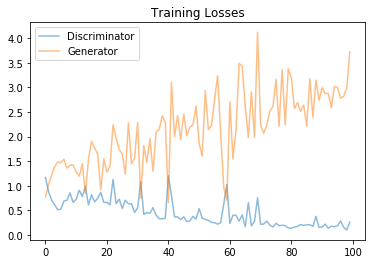

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

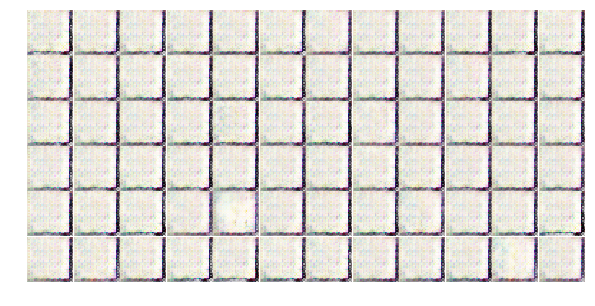

In [21]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))